In [1]:
from bib import *
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Activation
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
xtrains,ytrains,xvals,yvals,xtest,ytest=split(('CHL 1','THERM 1','SSH','SR','WS'),
                                               ['CHL '+ str(i) for i in range(2,19)])
ytrains,yvals,ytest=applyToy(lambda x:np.log(x)/np.log(10),ytrains,yvals,ytest)

In [3]:
def generate(arch):
    layers=[]
    for index,size in enumerate(arch):
        if index ==0:
            layers.append(Dense(size, input_shape=(5,),activation='relu'))

        else:
            layers.append(Dense(size,activation='relu'))
    layers.append(Dense(17,activation='linear',kernel_regularizer=regularizers.l2(0.01)))
    
    model = Sequential(layers)
    model.compile(optimizer='adam',
              loss='mse')
    return model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

In [ ]:
def validate(xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    for xt,yt,xv,yv in zip(xtrains,ytrains,xvals,yvals):
        model=generate([100,100,40])
        
        mean=xt.mean()
        std=xt.std()
        
        xt=(xt-mean)/std
        xv=(xv-mean)/std
        
        
        
        model.fit(xt.values,yt.values,
                  epochs=100,
                  callbacks=callbacks,
                  verbose=0,
                  batch_size=73*10, 
                  validation_data=(xv.values,yv.values))
        
        yp = model.predict(xv.values)
        
        #check error in original space
        yp=np.exp(yp*np.log(10))-1
        yv=np.exp(yv*np.log(10))-1
        
        fold_evaluation.append(evaluate(yp,yv))
    return np.mean(fold_evaluation),np.std(fold_evaluation )


In [ ]:

print(' Trainin results : error %.4f +- %.4f'% \
      validate(xtrains,ytrains,xvals,yvals))

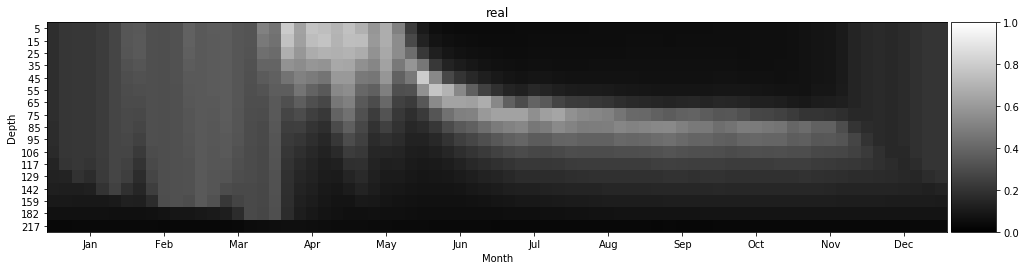

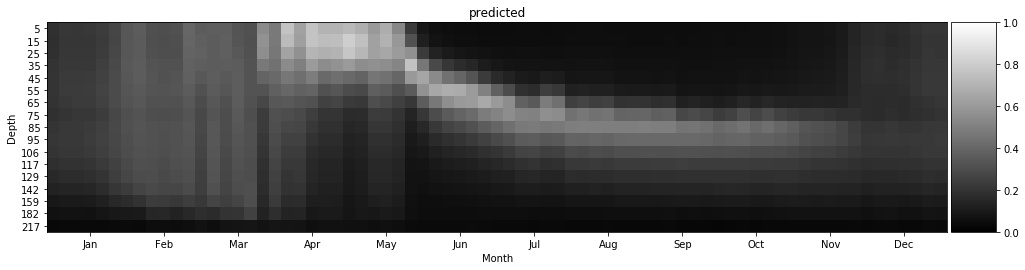

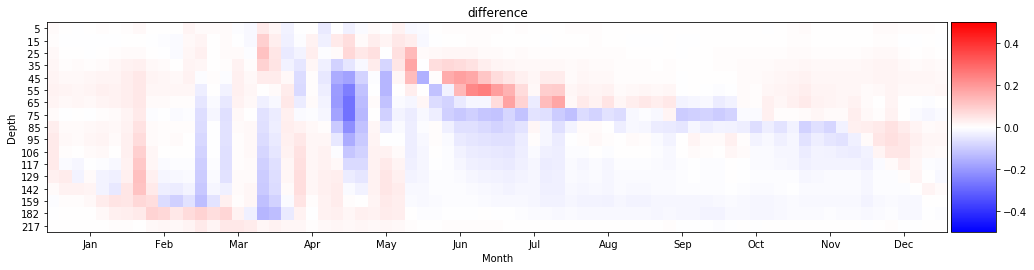

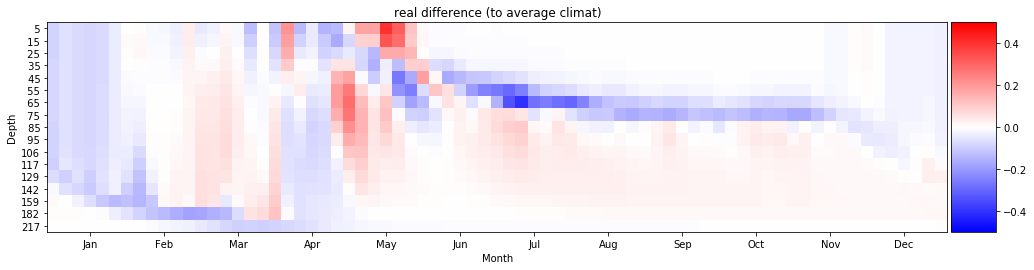

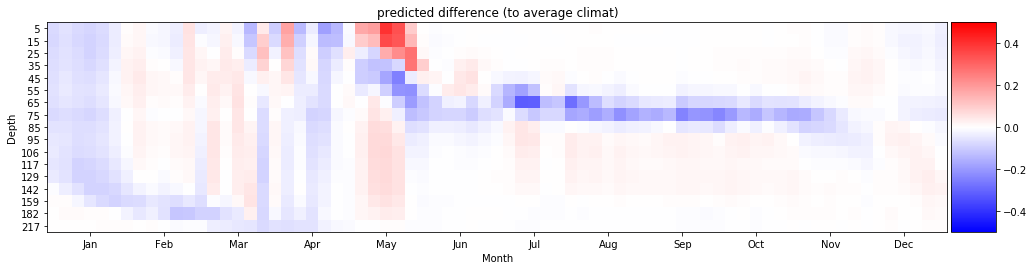

In [34]:
model=generate([100,100,40])
mean=xtrains[0].mean()
std=xtrains[0].std()

xt=(xtrains[0]-mean)/std
xv=(xvals[0]-mean)/std

model.fit(xt.values,ytrains[0].values,
          epochs=10000,
          callbacks=callbacks,
          verbose=0,
          batch_size=73*10, 
          validation_data=(xv.values,yvals[0].values))
xt=(xtest-mean)/std
yp = model.predict(xt.values)


yp=np.exp(yp*np.log(10))
yt=np.exp(ytest*np.log(10)).values


plotYear(yt,title='real')
plotYear(yp,title='predicted')
plotYear(yp-yt,title='difference',c='bwr',d=True)
climato(yt,title='real difference (to average climat)')
climato(yp,title='predicted difference (to average climat)')